<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Working/StocksApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**


In [21]:
# #refesh python script
# get_ipython().kernel.do_shutdown(restart=True)

# #Check GPUs
# !nvidia-smi

#load cudf to use GPUs for analysis
#%load_ext cudf.pandas

# import pandas
import pandas as pd
import datetime
import pickle
import numpy as np
from tqdm.notebook import tqdm
import requests
from datetime import datetime, timedelta
import time
import os

#!pip install tqdm==4.66.1



# Ensure the last 6 months of EODHD Data is available

In [22]:
# Ensure the last 6 months of EODHD Data is available

#API_KEY = 'demo'  # Replace with your API key if not using demo
API_KEY = '68433aff09ea73.10710364'
EXCHANGE = 'NASDAQ'
DAYS_BACK = 180  # Approx. 6 months
SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv'
MAX_CALLS_PER_RUN = 200  # Use 1–5 for the free tier
SECONDS_BETWEEN_CALLS = 0  # Add delay to be respectful

# Generate past 6 months of weekdays
today = datetime.utcnow().date()
dates = [today - timedelta(days=i) for i in range(DAYS_BACK)]
dates = sorted([d for d in dates if d.weekday() < 5])  # Keep only weekdays

# Load already-downloaded dates if file exists
downloaded_dates = set()
if os.path.exists(SAVE_PATH):
    df_existing = pd.read_csv(SAVE_PATH)
    downloaded_dates = set(pd.to_datetime(df_existing['date']).dt.date)
# Filter to only dates we haven’t downloaded
pending_dates = [d for d in dates if d not in downloaded_dates]

# Prepare data holder
all_data = []

for i, date in enumerate(pending_dates[:MAX_CALLS_PER_RUN]):
    date_str = date.strftime('%Y-%m-%d')
    url = f'https://eodhd.com/api/eod-bulk-last-day/{EXCHANGE}?api_token={API_KEY}&fmt=json&date={date_str}'
    print(f"[{i+1}] Fetching {date_str}...")

    try:
        response = requests.get(url)
        response.raise_for_status()
        day_data = response.json()

        for entry in day_data:
            all_data.append({
                'date': entry.get('date'),
                'ticker': entry.get('code'),
                'open': entry.get('open'),
                'high': entry.get('high'),
                'low': entry.get('low'),
                'close': entry.get('close'),
                'adjusted_close': entry.get('adjusted_close'),
                'volume': entry.get('volume'),
            })

        # Respect the delay
        if i < MAX_CALLS_PER_RUN - 1:
            time.sleep(SECONDS_BETWEEN_CALLS)

    except Exception as e:
        print(f"⚠️ Error on {date_str}: {e}")

# Append or save the new data
if all_data:
    df_new = pd.DataFrame(all_data)
    if os.path.exists(SAVE_PATH):
        df_existing = pd.read_csv(SAVE_PATH)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df_combined = df_new

    df_combined.to_csv(SAVE_PATH, index=False)
    print(f"✅ Data for {len(all_data)} entries added to {SAVE_PATH}")
else:
    print("⚠️ No new data fetched.")

# Import CSV into code
nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")

[1] Fetching 2025-06-10...
⚠️ No new data fetched.


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get list of Tickers with Min Market Cap

In [24]:

# -------------------- CONFIG --------------------
API_KEY = '68433aff09ea73.10710364'  # Replace with your EODHD key
MIN_MARKET_CAP = 10_000_000_000  # Changeable: $1B, $10B, etc.
EXCHANGE = 'NASDAQ'
RESULTS_PER_PAGE = 500  # Max per EODHD API
# ------------------------------------------------

def get_filtered_nasdaq_stocks(api_key, min_cap, exchange="NASDAQ"):
    all_data = []
    offset = 0

    while True:
        url = (
            "https://eodhd.com/api/screener"
            f"?api_token={api_key}"
            f"&filters=["
            f'["exchange","=","{exchange}"],'
            #f'["type","=","Common Stock"],'
            f'["market_capitalization",">=",{min_cap}]'
            f"]"
            f"&sort=market_capitalization.desc"
            f"&limit={RESULTS_PER_PAGE}&offset={offset}&fmt=json"
        )

        response = requests.get(url)
        result = response.json()
        batch = result.get("data", [])

        if not batch:
            break

        all_data.extend(batch)
        offset += RESULTS_PER_PAGE

    return pd.DataFrame(all_data)

# Run filter
min_market_cap_df = get_filtered_nasdaq_stocks(API_KEY, MIN_MARKET_CAP)



# Filter nasdaq for common stocks and min_market_cap

meta_url = f'https://eodhd.com/api/exchange-symbol-list/NASDAQ?api_token={API_KEY}&fmt=json'
meta_df = pd.DataFrame(requests.get(meta_url).json())
common_df = meta_df[meta_df['Type'] == 'Common Stock']



In [25]:
min_market_cap_df.head()

,code,name,last_day_data_date,adjusted_close,refund_1d,refund_1d_p,refund_5d,refund_5d_p,exchange,currency_symbol,market_capitalization,earnings_share,dividend_yield,sector,industry,avgvol_1d,avgvol_200d
0,MSFT,Microsoft Corporation,2025-06-09,472.75,2.37,0.50,10.7800,2.33,US,$,3513733349376,12.95,0.0070,Technology,Software - Infrastructure,16456400,2.180905e+07
1,NVDA,NVIDIA Corporation,2025-06-09,142.63,0.91,0.64,5.2500,3.82,US,$,3478403678208,3.10,0.0003,Technology,Semiconductors,185114494,2.646526e+08
2,AAPL,Apple Inc,2025-06-09,201.45,-2.47,-1.21,-0.2500,-0.12,US,$,3045722423296,6.43,0.0052,Technology,Consumer Electronics,72726700,5.319473e+07
3,AMZN,Amazon.com Inc,2025-06-09,216.98,3.41,1.60,10.3300,5.00,US,$,2303546359808,6.14,NaN,Consumer Cyclical,Internet Retail,38102502,4.144809e+07
4,GOOGL,Alphabet Inc Class A,2025-06-09,176.09,2.62,1.51,7.2644,4.30,US,$,2114330296320,8.96,0.0048,Communication Services,Internet Content & Information,28935906,3.140211e+07


# Filter nasdaq data for common and min_market_cap

In [26]:
# prompt: I want to filter the Nasdaq stocks to only include tickers that are part of the common_df and the min_market_cap_df. Same this df as a new variable
# Load your EOD data
from datetime import datetime, timedelta
# nasdaq_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nasdaq_bulk_eod.csv")
nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])

filtered_nasdaq_df = nasdaq_df[
    nasdaq_df['ticker'].isin(common_df['Code']) &
    nasdaq_df['ticker'].isin(min_market_cap_df['code'])
]

# Function: Correlation Coeficient for entire stock data set

In [27]:
# prompt: I want to modify the function calculate_lagged_correlation to be able to take in the nasdaq_df variable.
# Also, I do not want to put in the end date. The function will automatically select the start_datetime by
# subtracting the range_months from today’s date.

import pandas as pd
from datetime import datetime # Import datetime
from tqdm.notebook import tqdm # Import tqdm

# ## Function: Correlation Coeficient for entire stock data set
def calculate_lagged_correlation(df, lag_days, range_months):
  """
  Calculates the pairwise spearman correlation coefficient between all stocks
  in a DataFrame for a specified period with a given lag.
  The start date is calculated by subtracting range_months from today's date.

  Args:
    df: DataFrame with 'date', 'ticker', and 'adjusted_close' columns.
    lag_days: The number of days to lag the second stock's data.
    range_months: The number of months to include in the analysis period.

  Returns:
    A pandas DataFrame containing the pairwise correlation coefficients.
  """
  # Calculate the end date (today's date)
  end_datetime = datetime.now()

  # Calculate the start date for the specified period by subtracting range_months
  start_datetime = end_datetime - pd.DateOffset(months = range_months)


  # Ensure the 'date' column is in datetime format
  df['date'] = pd.to_datetime(df['date'])

  # Filter the DataFrame for the specified date range
  filtered_df = df[(df['date'] >= start_datetime) & (df['date'] <= end_datetime)].copy()

  # Filter out rows where volume is 0
  filtered_df = filtered_df[filtered_df['volume'] > 0].copy()

  # Get unique tickers in the filtered data
  tickers = filtered_df['ticker'].unique()

  #breakpoint()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker and name the series for clarity
    stock_a_data = filtered_df[filtered_df['ticker'] == ticker_a].set_index('date')['adjusted_close']
    #breakpoint()

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker and name the series for clarity
        stock_b_data = filtered_df[filtered_df['ticker'] == ticker_b].set_index('date')['adjusted_close']
        #breakpoint()

        # Align the dataframes based on the date index
        # Suffixes will be applied to the 'adjusted_close' column name
        aligned_data = pd.merge(stock_a_data, stock_b_data,
                                left_index=True, right_index=True,
                                how='inner', suffixes=('_A', '_B'))

        # Apply the lag to stock_b_data, referencing the suffixed column name
        lagged_stock_b_data = aligned_data['adjusted_close_B'].shift(lag_days)

        #breakpoint()

        # Calculate correlation, dropping NaN values
        # Using Spearman method and minimum periods
        #correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman', min_periods=100)

        correlation = aligned_data['adjusted_close_A'].corr(lagged_stock_b_data, method='spearman')


        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix

# enter end date and run correlation function on entire stock data. This will take a couple of hours




In [28]:
# prompt: Can you check my Google drive for three_month_spearman_lagged_correlations and six_month_spearman_lagged_correlations first and pull in those CSVs if found. If not, run the calculate_lagged_correlation function and save these csvs as Today’s date_six_month_spearman_lagged_correlation and today’s date_three_month_spearman_lagged_correlation

import pandas as pd
import os
from datetime import datetime

# Define the file paths in Google Drive
today_str = datetime.now().strftime('%Y%m%d')
three_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{today_str}_three_month_spearman_lagged_correlation.csv'
six_month_file = f'/content/drive/MyDrive/Colab Notebooks/Correlation_Data/{today_str}_six_month_spearman_lagged_correlation.csv'

# Check if files exist and load them
try:
    three_month_spearman_lagged_correlations = pd.read_csv(three_month_file, index_col=0)
    print(f"Loaded existing file: {three_month_file}")
    six_month_spearman_lagged_correlations = pd.read_csv(six_month_file, index_col=0)
    print(f"Loaded existing file: {six_month_file}")

except FileNotFoundError:
    print("One or both correlation files not found. Calculating correlations...")
    # Calculate correlations if files don't exist
    # Ensure 'filtered_nasdaq_df' is defined from the preceding code
    if 'filtered_nasdaq_df' in locals():
        three_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=3)
        six_month_spearman_lagged_correlations = calculate_lagged_correlation(filtered_nasdaq_df, lag_days=1, range_months=6)

        # Save the newly calculated correlations to Google Drive
        three_month_spearman_lagged_correlations.to_csv(three_month_file)
        print(f"Saved calculated file: {three_month_file}")
        six_month_spearman_lagged_correlations.to_csv(six_month_file)
        print(f"Saved calculated file: {six_month_file}")
    else:
        print("Error: 'filtered_nasdaq_df' is not defined. Please ensure the preceding code ran correctly.")

Loaded existing file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250610_three_month_spearman_lagged_correlation.csv
Loaded existing file: /content/drive/MyDrive/Colab Notebooks/Correlation_Data/20250610_six_month_spearman_lagged_correlation.csv


# Corr_Momentum and Unified_Factor

In [29]:
# prompt: I want to generate a corr_momentum_df which is the three_month_spearman_lagged_correlation minus the six_month_spearman_lagged_correlations

# Generate the momentum correlation dataframe
corr_momentum_df = three_month_spearman_lagged_correlations - six_month_spearman_lagged_correlations

# prompt: I want to generate a unified_factor_df which is the absolute value of the three_month_spearman_lagged_correlation minus the absolute value of the corr_momentum_df

unified_factor_df = three_month_spearman_lagged_correlations.abs() - corr_momentum_df.abs()

# Process correlated Data

In [37]:
def process_stock_correlations(
    correlation_df,
    min_market_cap_df,
    min_nodes,
    max_nodes,
    threshold_percent,
    min_planet_size=0.05,
    max_planet_size=1.5
):
    """
    Processes stock correlation data, filtering for top positive correlations and
    normalizing values for visualization. Orbital Radius is based on correlation
    strength, and Planet Radius is based on the target company's market capitalization.

    Args:
      correlation_df: DataFrame with tickers as index/columns and correlation
                      coefficients as values.
      min_market_cap_df: DataFrame containing at least 'code' (ticker) and
                         'market_capitalization' columns.
      min_nodes: The minimum number of correlated stocks to return per source stock.
      max_nodes: The maximum number of correlated stocks to return per source stock.
      threshold_percent: A percentage (0.0 to 1.0) of the max correlation to use as a
                         filtering threshold.
      min_planet_size: The minimum radius for a planet in the visualization (default 0.1).
      max_planet_size: The maximum radius for a planet in the visualization (default 1.0).

    Returns:
      A pandas DataFrame with processed correlation data, ready for visualization.
    """
    # --- Data Unpivoting and Initial Setup ---
    correlation_df = correlation_df.rename_axis('ticker_a', axis=0)
    grouped_correlation_data = correlation_df.stack().reset_index()
    grouped_correlation_data.columns = ['ticker_a', 'ticker_b', 'correlation']
    grouped_correlation_data = grouped_correlation_data[grouped_correlation_data['ticker_a'] != grouped_correlation_data['ticker_b']].copy()
    grouped_correlation_data['coefficient_of_determination'] = grouped_correlation_data['correlation']**2

    # --- Correlation Filtering Logic ---
    filtered_data_list = []
    for ticker_a, group_df in grouped_correlation_data.groupby('ticker_a'):
        positive_corr_group = group_df[group_df['correlation'] > 0].copy()
        if positive_corr_group.empty:
            continue

        max_correlation = positive_corr_group['correlation'].max()
        #threshold = max_correlation * threshold_percent
        threshold = 0.8
        filtered_group_df_threshold = positive_corr_group[positive_corr_group['correlation'] >= threshold]

        if len(filtered_group_df_threshold) < min_nodes:
            filtered_group_df = positive_corr_group.sort_values(by='correlation', ascending=False).head(min_nodes).copy()
        elif len(filtered_group_df_threshold) > max_nodes:
            filtered_group_df = filtered_group_df_threshold.sort_values(by='correlation', ascending=False).head(max_nodes).copy()
        else:
            filtered_group_df = filtered_group_df_threshold.copy()

        filtered_data_list.append(filtered_group_df)

    if not filtered_data_list:
        return pd.DataFrame(columns=['source', 'target', 'correlation', 'coefficient_of_determination', 'Orbital Radius', 'Planet Radius'])

    most_correlated_stocks = pd.concat(filtered_data_list)

    # --- Normalization Logic Updated for Market Cap ---

    # Create a dictionary for fast market cap lookups. This is much faster
    # than searching the DataFrame for each row inside the .apply() method.
    market_cap_dict = min_market_cap_df.set_index('code')['market_capitalization'].to_dict()

    # Get the overall min and max market caps from your provided DataFrame
    # This is used to create a consistent logarithmic scale for planet sizes.
    # Add a small epsilon to avoid log(0) errors if a market cap is 0.
    epsilon = 1e-9
    global_min_market_cap = min_market_cap_df['market_capitalization'].replace(0, epsilon).min()
    global_max_market_cap = min_market_cap_df['market_capitalization'].max()

    # Pre-calculate log values for normalization
    log_min_mc = np.log(global_min_market_cap)
    log_max_mc = np.log(global_max_market_cap)

    # Calculate min/max for correlation normalization within each group
    min_max_correlations = most_correlated_stocks.groupby('ticker_a')['correlation'].agg(['min', 'max'])

    def normalize_row(row, min_max_corr_df):
        ticker_a = row['ticker_a']
        target_ticker = row['ticker_b']
        correlation_val = row['correlation']

        # --- Orbital Radius Calculation (unchanged) ---
        min_corr, max_corr = min_max_corr_df.loc[ticker_a]
        orbital_radius = 0.0 if max_corr == min_corr else 1 - ((correlation_val - min_corr) / (max_corr - min_corr))

        # --- Planet Radius Calculation (New Logic) ---
        # Look up the market cap for the TARGET stock ('ticker_b')
        market_cap = market_cap_dict.get(target_ticker, global_min_market_cap)
        market_cap = max(market_cap, epsilon) # Ensure market cap is not zero

        # Normalize market cap to a 0-1 scale using a logarithmic scale.
        # This prevents a few mega-cap stocks from dwarfing all others visually.
        log_mc = np.log(market_cap)
        normalized_mc = 0.0 if log_max_mc == log_min_mc else (log_mc - log_min_mc) / (log_max_mc - log_min_mc)

        # Scale the normalized value to the desired min/max planet size range.
        planet_radius = min_planet_size + (normalized_mc * (max_planet_size - min_planet_size))

        # Ensure planet radius is within bounds, just in case of float precision issues.
        planet_radius = max(min_planet_size, min(planet_radius, max_planet_size))

        return pd.Series([orbital_radius, planet_radius], index=['Orbital Radius', 'Planet Radius'])

    # Apply the updated normalization function
    normalized_values = most_correlated_stocks.apply(
        normalize_row,
        axis=1,
        args=(min_max_correlations,)
    )
    most_correlated_stocks[['Orbital Radius', 'Planet Radius']] = normalized_values

    # Final cleanup and renaming
    most_correlated_stocks_long = most_correlated_stocks.reset_index(drop=True)
    most_correlated_stocks_long = most_correlated_stocks_long.rename(columns={'ticker_a': 'source', 'ticker_b': 'target'})

    return most_correlated_stocks_long


# Create Network Diagram

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import random # Added random for shuffling node positions

def plot_ticker_network_visual(correlated_data, source_ticker):
    """
    Plots a network graph for a specific ticker and its most correlated partners.
    The source_ticker node is yellow and larger, with its label black, bold, and centered.
    Orbiting nodes are deep blue, with their labels bold and white, centered on the node.
    Orbiting nodes have their correlation percentage displayed closer underneath them,
    colored green for positive and red for negative.
    Edges (lines) between nodes are not drawn.
    Nodes are randomly but evenly spaced around the central node.
    The overall plot size is reduced.

    Args:
      correlated_data: DataFrame with columns 'source', 'target', 'correlation',
                       'Orbital Radius', 'Planet Radius'.
      source_ticker: The ticker for which to generate the network graph.
    """
    # Filter the data to include only connections where the source ticker is the source
    # Using .copy() to avoid SettingWithCopyWarning
    ticker_connections = correlated_data[correlated_data['source'] == source_ticker].copy()

    # Handle cases where there are no connections found after filtering
    if ticker_connections.empty:
        print(f"No connections found for ticker {source_ticker} as the source within the provided data.")
        return

    # Create a graph.
    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                ['correlation', 'Orbital Radius', 'Planet Radius'])

    # Ensure the source_ticker is actually in the graph after creation
    if source_ticker not in G:
        G.add_node(source_ticker)


    # Customize graph visualization
    # Reduce overall plot size
    plt.figure(figsize=(8, 6)) # Reduced from (10, 8)

    fig = plt.gcf()  # Get the current figure
    ax = plt.gca()   # Get the current axes

    # --- SET BACKGROUND TO BLACK ---
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')  # The area where the network is drawn

    # --- Positioning based on 'Orbital Radius' ---
    pos = {}
    pos[source_ticker] = (0, 0) # Center the source_ticker

    actual_target_connections = ticker_connections[ticker_connections['target'] != source_ticker]
    num_connections = len(actual_target_connections)

    if num_connections > 0:
        angles = [i * (2 * np.pi / num_connections) for i in range(num_connections)]
        random.shuffle(angles)
        target_nodes_for_positioning = list(actual_target_connections['target'])

        for i, target_node_name in enumerate(target_nodes_for_positioning):
            row = actual_target_connections[actual_target_connections['target'] == target_node_name].iloc[0]
            orbital_radius = row['Orbital Radius']
            min_distance = 0.3
            current_orbital_radius = orbital_radius + min_distance

            orbit_patch = plt.Circle((0, 0), current_orbital_radius,
                                     fill=False,
                                     linestyle='--',
                                     edgecolor='gray',
                                     linewidth=0.7,
                                     alpha=0.6)
            ax.add_patch(orbit_patch)

            angle = angles[i]
            x = current_orbital_radius * np.cos(angle)
            y = current_orbital_radius * np.sin(angle)
            pos[target_node_name] = (x, y)

    if not pos and source_ticker in G:
        pos[source_ticker] = (0,0)

    # --- Node Sizes based on 'Planet Radius' ---
    node_sizes_dict = {}
    node_sizes_dict[source_ticker] = 1500

    for _idx, row in ticker_connections.iterrows():
        target = row['target']
        if target != source_ticker:
            planet_radius = row['Planet Radius']
            if not isinstance(planet_radius, (int, float)):
                planet_radius = 0
            scaled_size = 300 + (planet_radius * 500)
            node_sizes_dict[target] = scaled_size
        elif target == source_ticker and source_ticker not in node_sizes_dict:
             planet_radius = row['Planet Radius']
             if not isinstance(planet_radius, (int, float)):
                planet_radius = 0
             scaled_size = 300 + (planet_radius * 500)
             node_sizes_dict[source_ticker] = scaled_size

    node_sizes_list = [node_sizes_dict.get(node, 300) for node in G.nodes()]

    # --- Node Colors: Center node yellow, others deep blue ---
    node_colors_list = []
    for node in G.nodes():
        if node == source_ticker:
            node_colors_list.append('yellow')
        else:
            # Changed to a deep blue color
            node_colors_list.append('blue') # You can also use hex codes like '#00008B'

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=0.9, linewidths=0)

    # --- EDGES ARE NOT DRAWN ---

    # --- Draw Correlation Labels Underneath Orbiting Nodes ---
    for _idx, row in actual_target_connections.iterrows():
        target_node = row['target']
        correlation = row['correlation']

        if target_node in pos:
            node_x, node_y = pos[target_node]
            label_color = 'green' if correlation >= 0 else 'red'
            label_text = f"{correlation:.1%}"
            vertical_offset = 0.08

            plt.text(node_x, node_y - vertical_offset, label_text,
                     color=label_color,
                     ha='center',
                     va='top',
                     fontsize=9,
                     fontweight='bold')

    # --- Draw Node Labels (Ticker Names) ---
    for node in G.nodes():
        if node not in pos:
            continue

        node_x, node_y = pos[node]

        if node == source_ticker:
            # Center node: bold, black, centered inside the node
            plt.text(node_x, node_y, str(node),
                     color='black',
                     fontweight='bold',
                     fontsize=8,
                     ha='center',
                     va='center')
        else:
            # Orbiting nodes: bold, white, centered on the node
            plt.text(node_x, node_y, str(node),
                     color='white',
                     fontweight='bold',
                     fontsize=8,
                     ha='center',
                     va='center')

    plt.title(f'Network for {source_ticker} and Most Correlated Partners', color='white')
    plt.axis('off')
    plt.show()



#Run App

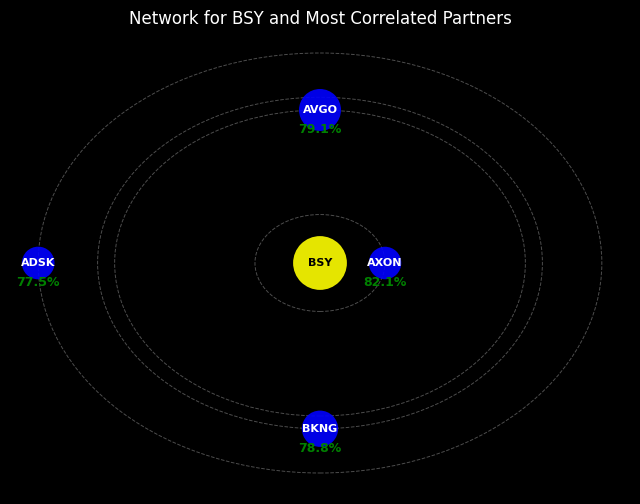

In [41]:
# Example usage with the sixMonth_correlation_data
min_nodes = 4
max_nodes = 50
threshold_percent = 0.90

exclude_financials = True
range_months = 3
ticker = 'BSY'

processed_data = process_stock_correlations(unified_factor_df, min_market_cap_df, min_nodes, max_nodes, threshold_percent)
plot_ticker_network_visual(processed_data, ticker)

# #processed_data = process_stock_correlations(one_month_spearman_lagged_correlations, min_nodes, max_nodes, threshold_percent)
# if range_months == 6:
#   processed_data = process_stock_correlations(six_month_spearman_lagged_correlations, min_nodes, max_nodes, threshold_percent)
#   plot_ticker_network_visual(processed_data, ticker)
# elif range_months == 3:
#   three_month_processed_data = process_stock_correlations(three_month_spearman_lagged_correlations, min_nodes, max_nodes, threshold_percent)
#   plot_ticker_network_visual(processed_data, ticker)
# else:
#   print("Invalid range_months value. Please choose 3 or 6.")


